# IMDb Review Emotion Classifier

<img src="tenor.gif">

IMDb (Internet Movie Database) is an online database of information related to films, television programs, home videos and video games, and internet streams, including cast, production crew and personnel biographies, plot summaries, trivia, and fan reviews and ratings.

## Understanding the Problem

Here, We aim to classify review into having a Positive or Negative Sentiment (0 or 1) . We are given a bunch of text reviews from the IMDb Website and the labels to classify them on the basis of. We will use the help of Word Embeddings to transform the Words into numbers and then we'll make predictions upon it.

### Sentiment Analysis

Here, We aim to classify review into having a Positive or Negative Sentiment(0 or 1). We are given a bunch of text reviews from the IMDb Website and the labels to classify them on the basis of. We will use the help of Word Embeddings to transform the Words into numbers and then we'll make predictions upon it.

Now, As we know about Sentiment analysis, let's apply it.

## Importing the required libraries

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import nltk   
from nltk.corpus import stopwords 

#At first you will have to download stopwords which can be downloaded by nltk.dowload('stopwords') 

from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

## Importing the Dataset

In [22]:
data=pd.read_csv("imdb_labelled.txt",sep="\t")
data.columns=['Review','P/N']

In [5]:
data.head()

,Review,P/N
0,Not sure who was more lost - the flat characte...,0
1,Attempting artiness with black & white and cle...,0
2,Very little music or anything to speak of.,0
3,The best scene in the movie was when Gerardo i...,1
4,"The rest of the movie lacks art, charm, meanin...",0


data.head() shows the first 5 values of the dataset

In [6]:
data.describe()

,P/N
count,747.000000
mean,0.516734
std,0.500055
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [7]:
print("Total Data: {}".format(data.shape[0]))
print("Total Positive Sentiment Data Points: {}".format(data[data['P/N']==1].shape[0]))
print("Total Negative Sentiment Data Points: {}".format(data[data['P/N']==0].shape[0]))

Total Data: 747
Total Positive Sentiment Data Points: 386
Total Negative Sentiment Data Points: 361


We have a total of 747 data points, out of which 386 are positive sentiment and 361 are negative sentiment. Therefore, the amount of positive nd negative data is almost of the same size. So, there is not much of an imbalance.
A total of:

    - 386 data points are positive sentiment.
       and
    - 361 data points are negative sentiment.

## Performing EDA

EDA or Exploratory Data Analysis is the process of gathering useful informations and insights from data. EDA helps us in a better understanding of the data and the trends it follows.

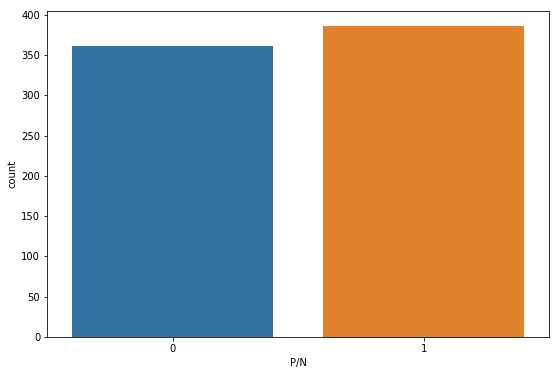

In [9]:
plt.figure(figsize=(9,6))
sns.countplot(data=data,x='P/N')
plt.show()

Count Plots
Count plots help us to quantitatively visualise the data on the basis of count of a given feature.

According to our dataset,
<ol>
    <li> The blue bar represents 0 ,i.e. the negative reviews.</li>
    <li>The orange bar represens 1,i.e. the positive reviews.</li>
</ol>

In [23]:
def get_length(x):
    y=x.split(" ")
    return len(y)
data['length']=data['Review'].apply(get_length)

Here we have defined a function to calculate the length of each review which will help us in further processes

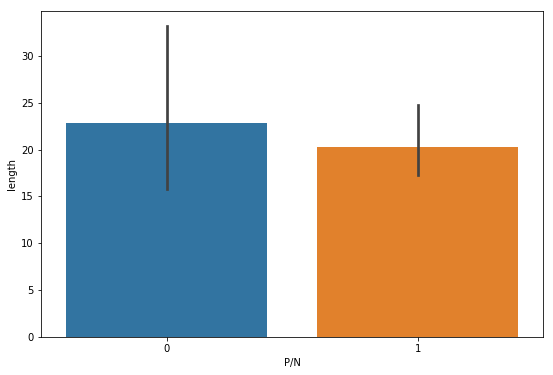

In [11]:
plt.figure(figsize=(9,6))
sns.barplot(data=data,x='P/N',y="length")
plt.show()

Bar Plot
Bar plot helps us visualise the ralationship between 2 diffrent features of a dataset in the form of bars. 
In this Case,<br>
The above plot helps us to understand that mostly, the people who write negative reviews use more words than the people who write positive reviews. Which is true in most of the cases as you can describe what is postive in few details, but if you tell what is negative you have to describe what you didn't like or what part needs an improvement.



In [24]:
word_list=set(stopwords.words('english'))
def Clean(x):
    l=[]
    for i in x.lower().split(" "):
        if i in word_list:
            continue
        else:
            l.append(i)
    return " ".join(l)
data['Clean_text']=data['Review'].apply(Clean)

Before we start conducting analysis on the text data, We first need to remove stopwords from the data.

<h5>Stopwords</h5>

Stopwords are words which do not provide some useful information in a sentence. Words like 'a','the' etc. are stopwords. These words although present in the sentence, do not contain any valuable information. 
Hence, They can be removed.

<h5>WordCloud</h5>
Wordclouds are images which visually represent the frequency of occurence of specific words. The more the words occur in a given dataset, the bigger size it has in wordcloud.

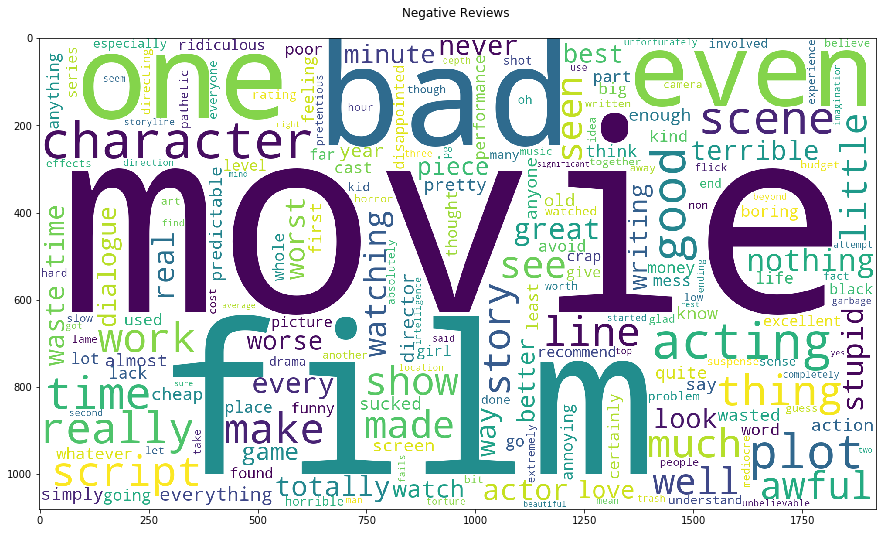

In [13]:
neg=data[data['P/N']==0]
neg_Token=[]

for i in neg['Clean_text']:
        neg_Token=neg_Token+i.split(" ")
neg_Corpus=" ".join(neg_Token)
wc=WordCloud(height=1080,width=1920,background_color='white').generate(neg_Corpus)

plt.figure(figsize=(15,12))
plt.title("Negative Reviews \n")
plt.imshow(wc)
plt.show()

The above wordcloud gives us the words which are maximum used in the negative reviews.
Words like:-
<ul>
<li>Movie</li>
<li>Film</li>
<li>Bad</li>
<li>Character</li>
<li>One</li>
</ul>
are present the most in negative reviews.

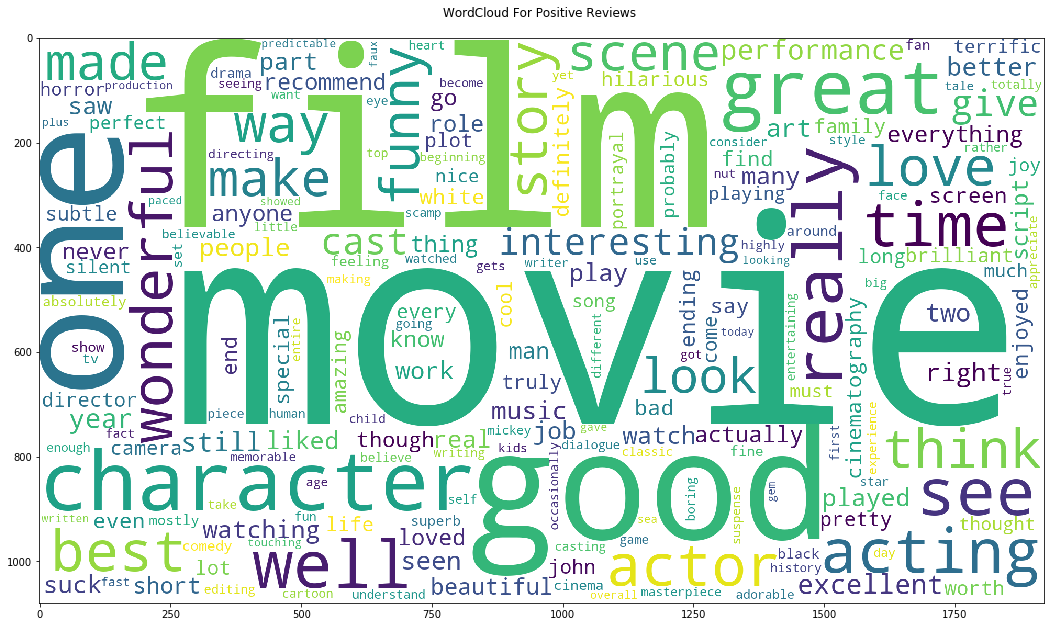

In [14]:
pos=data[data['P/N']==1]
pos_Token=[]
for i in pos['Clean_text']:
        pos_Token=pos_Token+i.split(" ")
pos_Corpus=" ".join(pos_Token)
wc=WordCloud(height=1080,width=1920,background_color='white').generate(pos_Corpus)
plt.figure(figsize=(18,12))
plt.title("WordCloud For Positive Reviews \n")
plt.imshow(wc)
plt.show()

The above wordcloud gives us the words which are maximum used in the positive sentiment reviews.<br>
Words like:-
<ul><li>Movie</li>
    <li>Film</li>
    <li>Good</li>
    <li>One</li>
    <li>Great</li>
</ul>
    are present the most in positive reviews.

### Performing NLP

NLP or Natural Language Processing is the process of analysing and creating an artificial intelligence model to understand the Human Language. As Computers don't understand the Human Languages, they understand Binary(0 and 1). So before modelling a machine learning model on our text based data, We need to convert the text to Numbers.<br>

<br>
To Convert The Text to numbers we have 3 techniques:-<br>
<ul><li>Bag of Words</li>
    <li>Term Frequency-Inverse Document Frequency</li>
    <li>Word Vectors</li>
</ul>

### Bag of Words

Bag Of Words or Count-Vectorizer is a technique which converts text into numbers on the basis of occurences in a document.
The bag-of-words model is commonly used in methods of document classification where the occurrence of each word is used as a feature for training a classifier.

But, Bag of words representation doesn’t consider the semantic relation between words.
<br>
Bag of words often results in excessive increase in the dimensions of the data.

### Term Frequency-Inverse Document Frequency

Term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general. Tf–idf is one of the most popular term-weighting schemes today.<br>

But, Term Frequency-Inverse Document Frequency has a severe Problem, It does not take sentiment into account. <br>
### Word Vectors

In very simplistic terms, Word Embeddings are the texts converted into numbers and there may be different numerical representations of the same text..<br><br>
So far, we have seen deterministic methods to determine word vectors. But these methods proved to be limited in their word representations until Mikolov et. el introduced word2vec to the NLP community. These methods were prediction based in the sense that they provided probabilities to the words and proved to be state of the art for tasks like word analogies and word similarities. They were also able to achieve tasks like King -man +woman = Queen, which was considered a result almost magical.

###### In this Dataset we will use Glove Vectors for converting Words to Numbers
###### GLOVE stands for GLObal VEctors for Word Representation

## Loading Word Vectors

In [15]:
glove2word2vec(glove_input_file='glove.6B.50d.txt',word2vec_output_file="Vectors.txt")
model=KeyedVectors.load_word2vec_format("Vectors.txt")

Now let's Make 2 DataFrames, Normalised Sentence Vectors and Non-Normalised Sentence Vectors.
<br>
<br>
<u> Non-Normalised Sentence Vectors=Sentence vector(S)[50-dim]= (word_vector(w1)+word_vector(w2)+word_vector(w3))+...</u>
<br>
<br>
<u> Normalised Sentence Vectors=Sentence vector normalized(S)[50-dim]= (word_vector(w1)+word_vector(w2)+word_vector(w3)+...)/ (number of words)</u>

In [25]:
lst=[0]*50
def sum(x,lst,ret_val):
    vec=lst
    for i in x:
        try:
            vec=np.add(vec,model[i])
        except:
            vec=np.add(vec,lst)
            continue
    return vec[ret_val]

In [26]:
unNorm=data
for i in range(50):
    unNorm['key'+str(i)]=unNorm['Clean_text'].apply(sum,args=[lst,i])
unNorm

,Review,P/N,length,Clean_text,key0,key1,key2,key3,key4,key5,...,key40,key41,key42,key43,key44,key45,key46,key47,key48,key49
0,Not sure who was more lost - the flat characte...,0,21,"sure lost - flat characters audience, nearly h...",-4.339941,39.864810,33.493761,37.196850,16.649266,2.702068,...,39.579793,9.138292,-12.954365,-3.565787,-3.513915,15.263419,9.764361,-15.799705,16.231830,50.392911
1,Attempting artiness with black & white and cle...,0,33,attempting artiness black & white clever camer...,-7.232397,103.757171,81.980295,82.588971,44.748976,-1.905478,...,99.094876,12.919981,-23.357448,-0.395946,-5.176439,38.732658,23.816379,-51.255765,46.230211,102.525621
2,Very little music or anything to speak of.,0,10,little music anything speak of.,-2.905241,21.723330,18.210816,17.232200,13.390500,-2.043094,...,18.652663,-1.712401,-4.709729,-0.177523,-3.421085,4.424772,5.618034,-10.497698,9.231130,21.872620
3,The best scene in the movie was when Gerardo i...,1,23,best scene movie gerardo trying find song keep...,-1.987123,44.036340,36.627725,37.216980,16.298460,0.390551,...,42.671819,7.053448,-10.196040,-4.496683,-8.286419,19.506372,10.326536,-23.713982,15.609057,58.496021
4,"The rest of the movie lacks art, charm, meanin...",0,22,"rest movie lacks art, charm, meaning... emptin...",-4.325489,50.504990,41.207369,42.969840,23.969276,1.587795,...,41.624616,4.672823,-6.009157,-1.764799,-7.724439,15.274791,11.531861,-24.583027,17.254985,45.676411
5,Wasted two hours.,0,5,wasted two hours.,-2.771752,13.583410,10.317590,12.448310,3.458022,-0.927016,...,12.267286,1.314681,-2.846480,-1.726785,0.550046,4.672023,1.521312,-6.482656,5.953987,14.152370
6,Saw the movie today and thought it was a good ...,1,17,"saw movie today thought good effort, good mess...",-4.130097,44.403860,27.412232,37.255250,13.813386,-2.530845,...,37.422145,3.672922,-3.665087,-9.097407,-1.464975,13.431522,6.952095,-23.091311,18.024414,47.208630
7,A bit predictable.,0,5,bit predictable.,-0.692560,8.456380,8.106114,8.757740,5.655800,2.299944,...,10.509388,2.909401,-3.316553,1.802952,0.047805,6.202280,2.383027,-5.545642,4.474929,14.401720
8,Loved the casting of Jimmy Buffet as the scien...,1,12,loved casting jimmy buffet science teacher.,-2.839451,29.446630,24.779769,26.721320,13.302030,-3.560957,...,33.195133,3.730676,-2.678092,-1.221563,-4.894443,13.589973,7.282146,-17.149308,11.214210,34.448670
9,And those baby owls were adorable.,1,8,baby owls adorable.,-1.211892,13.122110,5.737585,13.120260,5.738566,4.239280,...,11.705766,2.949823,-3.295181,-3.586294,-2.360601,6.356090,1.766281,-6.765473,9.896643,15.666740


The Glove Vectors are the words represented in numbers across 50 dimensions,
The above function returns the unnormalised sentence vectors for the sentence passed to it.

In [27]:
lst=[0]*50
def sum(x,lst,ret_val):
    vec=lst
    for i in x:
        try:
            vec=np.add(vec,model[i])
        except:
            vec=np.add(vec,lst)
            continue
    vec=np.divide(vec,len(vec))
    return vec[ret_val]

norm=data
for i in range(50):
    norm['key'+str(i)]=norm['Clean_text'].apply(sum,args=[lst,i])
norm

,Review,P/N,length,Clean_text,key0,key1,key2,key3,key4,key5,...,key40,key41,key42,key43,key44,key45,key46,key47,key48,key49
0,Not sure who was more lost - the flat characte...,0,21,"sure lost - flat characters audience, nearly h...",-0.086799,0.797296,0.669875,0.743937,0.332985,0.054041,...,0.791596,0.182766,-0.259087,-0.071316,-0.070278,0.305268,0.195287,-0.315994,0.324637,1.007858
1,Attempting artiness with black & white and cle...,0,33,attempting artiness black & white clever camer...,-0.144648,2.075143,1.639606,1.651779,0.894980,-0.038110,...,1.981898,0.258400,-0.467149,-0.007919,-0.103529,0.774653,0.476328,-1.025115,0.924604,2.050512
2,Very little music or anything to speak of.,0,10,little music anything speak of.,-0.058105,0.434467,0.364216,0.344644,0.267810,-0.040862,...,0.373053,-0.034248,-0.094195,-0.003550,-0.068422,0.088495,0.112361,-0.209954,0.184623,0.437452
3,The best scene in the movie was when Gerardo i...,1,23,best scene movie gerardo trying find song keep...,-0.039742,0.880727,0.732555,0.744340,0.325969,0.007811,...,0.853436,0.141069,-0.203921,-0.089934,-0.165728,0.390127,0.206531,-0.474280,0.312181,1.169920
4,"The rest of the movie lacks art, charm, meanin...",0,22,"rest movie lacks art, charm, meaning... emptin...",-0.086510,1.010100,0.824147,0.859397,0.479386,0.031756,...,0.832492,0.093456,-0.120183,-0.035296,-0.154489,0.305496,0.230637,-0.491661,0.345100,0.913528
5,Wasted two hours.,0,5,wasted two hours.,-0.055435,0.271668,0.206352,0.248966,0.069160,-0.018540,...,0.245346,0.026294,-0.056930,-0.034536,0.011001,0.093440,0.030426,-0.129653,0.119080,0.283047
6,Saw the movie today and thought it was a good ...,1,17,"saw movie today thought good effort, good mess...",-0.082602,0.888077,0.548245,0.745105,0.276268,-0.050617,...,0.748443,0.073458,-0.073302,-0.181948,-0.029300,0.268630,0.139042,-0.461826,0.360488,0.944173
7,A bit predictable.,0,5,bit predictable.,-0.013851,0.169128,0.162122,0.175155,0.113116,0.045999,...,0.210188,0.058188,-0.066331,0.036059,0.000956,0.124046,0.047661,-0.110913,0.089499,0.288034
8,Loved the casting of Jimmy Buffet as the scien...,1,12,loved casting jimmy buffet science teacher.,-0.056789,0.588933,0.495595,0.534426,0.266041,-0.071219,...,0.663903,0.074614,-0.053562,-0.024431,-0.097889,0.271799,0.145643,-0.342986,0.224284,0.688973
9,And those baby owls were adorable.,1,8,baby owls adorable.,-0.024238,0.262442,0.114752,0.262405,0.114771,0.084786,...,0.234115,0.058996,-0.065904,-0.071726,-0.047212,0.127122,0.035326,-0.135309,0.197933,0.313335


Above, We have Created a function which returns normalised Sentence Vectors for a sentence passed.

Then we have created a normalised Sentence Vector for each element of our data and then stored in the dataframe Norm.

### Preprocessing

In [28]:
norm=norm.drop(['Review','Clean_text','length'],axis=1)
unNorm=unNorm.drop(['Review','Clean_text','length'],axis=1)
Y_norm=norm['P/N']
Y_unNorm=unNorm['P/N']
norm=norm.drop(['P/N'],axis=1)
unNorm=unNorm.drop(['P/N'],axis=1)
# Splitting unnormalized data for training and testing
X_Train_unNorm,X_Test_unNorm,Y_Train_unNorm,Y_Test_unNorm=train_test_split(unNorm,Y_unNorm,test_size=0.2,
                                                                                   random_state=200)
# Splittinng normalized data for training and testing
X_Train_norm,X_Test_norm,Y_Train_norm,Y_Test_norm=train_test_split(norm,Y_norm,test_size=0.2,
                                                                                   random_state=200)

### Machine Learning Modelling (Un_normalised)
Now Comes the fun part!<br>
We will now make machine learning models on or data and then see how well they perform.
#### Using Naive Bayes
We will first use Naive Bayes Algorithm to make Predictions.<br>
Naive Bayes is an algorithm which uses probability to predict which class the Data pint belongs to.
It is generally known to work well on Text Based Data.

In [30]:
Nb=GaussianNB()
Nb.fit(X_Train_unNorm,Y_Train_unNorm)
Pred=Nb.predict(X_Test_unNorm)
print("Accuracy : {:.1f} %".format(accuracy_score(Pred,Y_Test_unNorm)*100))
print("F1-Score : {:.1f} ".format(f1_score(Pred,Y_Test_unNorm)))

Accuracy : 52.0 %
F1-Score : 0.7 


Accuracy is the measure of performacnce of our model on the basis of how many points did our model predict correctly.
<br>
<br>F1-Score on the other hand is an overall measure of a model’s accuracy.a good F1 score means that you have low false positives and low false negatives, so you’re correctly identifying real threats and you are not disturbed by false alarms.<br><br>

we will try to improve our reults by using diffremt models

#### Using Logistic Regression


Logistic regression is a classification algorithm that uses a sigmoid function to predict the likelihood of the point belonging to a specific class.

In [31]:
Lr=LogisticRegression()
Lr.fit(X_Train_unNorm,Y_Train_unNorm)
Pred=Lr.predict(X_Test_unNorm)
print("Accuracy : {:.1f} %".format(accuracy_score(Pred,Y_Test_unNorm)*100))
print("F1-Score : {:.1f} ".format(f1_score(Pred,Y_Test_unNorm)))

Accuracy : 53.3 %
F1-Score : 0.6 


We see that on using Logistic Regression the performance of our model has decreased further.<br>
Let's try to use SVM on this Data<br>
#### SVM
SVM or Support Vector Machine is a type of classification algorithm which tries to maximise the distance between our data and the Decision Boundary.

In [32]:
svm=SVC()
svm.fit(X_Train_unNorm,Y_Train_unNorm)
Pred=svm.predict(X_Test_unNorm)
print("Accuracy : {:.1f} %".format(accuracy_score(Pred,Y_Test_unNorm)*100))
print("F1-Score : {:.1f} ".format(f1_score(Pred,Y_Test_unNorm)))

Accuracy : 51.3 %
F1-Score : 0.5 


#### Random Forest Classifier
Random Forest Classifier is a type of Classification Algorithm that makes a number of decision trees and conducts a majority vote to predict the final outcome of a data point.

In [33]:
Rfc=RandomForestClassifier()
Rfc.fit(X_Train_unNorm,Y_Train_unNorm)
Pred=Rfc.predict(X_Test_unNorm)
print("Accuracy : {:.1f} %".format(accuracy_score(Pred,Y_Test_unNorm)*100))
print("F1-Score : {:.1f} ".format(f1_score(Pred,Y_Test_unNorm)))

Accuracy : 47.3 %
F1-Score : 0.4 


## Cross-Validation
### Random Search CV
Random search is an approach to parameter tuning that will sample algorithm parameters from a random distribution (i.e. uniform) for a fixed number of iterations. A model is constructed and evaluated for each combination of parameters chosen.

In [37]:
can={'n_estimators':[x*10 for x in range(1,40)],'criterion':['gini','entropy']}
Rc=RandomizedSearchCV(Rfc,param_distributions=can,cv=5)
Rc.fit(X_Train_unNorm,Y_Train_unNorm)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390], 'criterion': ['gini', 'entropy']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [38]:
print(Rc.best_score_)
Rc.best_estimator_.n_estimators

0.5812395309882747


360

In [60]:
Rfc=RandomForestClassifier(n_estimators=360)
Rfc.fit(X_Train_unNorm,Y_Train_unNorm)
Pred=Rfc.predict(X_Test_unNorm)
print("Accuracy : {:.1f} %".format(accuracy_score(Pred,Y_Test_unNorm)*100))
print("F1-Score : {:.1f} ".format(f1_score(Pred,Y_Test_unNorm)))

Accuracy : 58.7 %
F1-Score : 0.6 


With Randomized Search CV on our Non-Normalised Dataset, We have been able to boost up our accuracy to 56% and our f1 score to 0.7<br>Let's See if we can imporve upon our Logistic regression model too.

In [58]:
can={'C':[x/1000 for x in range(1,1000)],'penalty':['l1','l2']}
Rc=RandomizedSearchCV(Lr,param_distributions=can,cv=5)
Rc.fit(X_Train_unNorm,Y_Train_unNorm)

In [59]:
print('{:.2f}'.format(Rc.best_score_))
Rc.best_estimator_.C

0.52


0.806

In [64]:
Lr=LogisticRegression(C=0.806)
Lr.fit(X_Train_unNorm,Y_Train_unNorm)
Pred=Lr.predict(X_Test_unNorm)
print("Accuracy : {:.1f} %".format(accuracy_score(Pred,Y_Test_unNorm)*100))
print("F1-Score : {:.1f} ".format(f1_score(Pred,Y_Test_unNorm)))

Accuracy : 53.3 %
F1-Score : 0.6 


Using Random Search Cv we have pushed our accuracy for our Logistic Regression Model to 56% and f1 score to 0.7<br>
Let's See if we can improve our SVM model.

In [65]:
can={'C':[x/1000 for x in range(1,1000)],'gamma':[x/1000 for x in range(1,1000)],
       'kernel':['linear','poly','rbf']}
Rc=RandomizedSearchCV(svm,param_distributions=can,cv=5)
Rc.fit(X_Train_unNorm,Y_Train_unNorm)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'C': [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018, 0.019, 0.02, 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027, 0.028, 0.029, 0.03, 0.031, 0.032, 0.033, 0.034, 0.035, 0.036, 0.037, 0.038, 0.039, 0.0...0.991, 0.992, 0.993, 0.994, 0.995, 0.996, 0.997, 0.998, 0.999], 'kernel': ['linear', 'poly', 'rbf']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [67]:
print('{:.1f}'.format(Rc.best_score_))
print('{:.1f}'.format(Rc.best_estimator_.C))
print('{:.1f}'.format(Rc.best_estimator_.gamma))
Rc.best_estimator_.kernel

0.5
0.9
0.8


'rbf'

In [68]:
svm=SVC(kernel='rbf',C=0.9,gamma=0.8)
svm.fit(X_Train_norm,Y_Train_norm)
Pred=svm.predict(X_Test_norm)
print("Accuracy : {:.1f} %".format(accuracy_score(Pred,Y_Test_norm)*100))
print("F1-Score : {:.1f} ".format(f1_score(Pred,Y_Test_norm)))

Accuracy : 49.3 %
F1-Score : 0.4 


### Machine Learning Modelling (Normalised)
#### Naive Bayes 

In [69]:
Nb1=GaussianNB()
Nb1.fit(X_Train_norm,Y_Train_norm)
Pred=Nb1.predict(X_Test_norm)
print("Accuracy : {:.1f} %".format(accuracy_score(Pred,Y_Test_norm)*100))
print("F1-Score : {:.1f} ".format(f1_score(Pred,Y_Test_norm)))

Accuracy : 52.0 %
F1-Score : 0.7 


#### Logistic Regression

In [70]:
Lr1=LogisticRegression()
Lr1.fit(X_Train_norm,Y_Train_norm)
Pred=Lr1.predict(X_Test_norm)
print("Accuracy : {:.1f} %".format(accuracy_score(Pred,Y_Test_norm)*100))
print("F1-Score : {:.1f} ".format(f1_score(Pred,Y_Test_norm)))

Accuracy : 53.3 %
F1-Score : 0.6 


Using Logistic Regression, We get an accuracy of 56% and F1-Score of 0.7 which is not great.
#### SVM

In [71]:
svm=SVC(kernel='poly')
svm.fit(X_Train_norm,Y_Train_norm)
Pred=svm.predict(X_Test_norm)
print("Accuracy : {:.1f} %".format(accuracy_score(Pred,Y_Test_norm)*100))
print("F1-Score : {:.1f} ".format(f1_score(Pred,Y_Test_norm)))

Accuracy : 52.0 %
F1-Score : 0.7 


Using SVC, our model's Performance shows some improvement Further. The accuracy has inncreased to 56% and F1 Score has increased to 0.72
#### Random Forest Classifier

In [72]:
Rfc=RandomForestClassifier()
Rfc.fit(X_Train_norm,Y_Train_norm)
Pred=Rfc.predict(X_Test_norm)
print("Accuracy : {:.1f} %".format(accuracy_score(Pred,Y_Test_norm)*100))
print("F1-Score : {:.1f} ".format(f1_score(Pred,Y_Test_norm)))

Accuracy : 52.0 %
F1-Score : 0.4 


Let's Perform Cross Validation and Try to see if can improve our models further.

### Cross-Validation

#### Random Search CV

In [73]:
can={'n_estimators':[x*10 for x in range(1,40)],'criterion':['gini','entropy']}
Rc=RandomizedSearchCV(Rfc,param_distributions=can,cv=5)
Rc.fit(X_Train_norm,Y_Train_norm)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390], 'criterion': ['gini', 'entropy']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [74]:
print('{:.1f}'.format(Rc.best_score_))
Rc.best_estimator_.n_estimators

0.6


320

In [75]:
Rfc=RandomForestClassifier(n_estimators=320)
Rfc.fit(X_Train_norm,Y_Train_norm)
Pred=Rfc.predict(X_Test_norm)
print("Accuracy : {:.1f} %".format(accuracy_score(Pred,Y_Test_norm)*100))
print("F1-Score : {:.1f} ".format(f1_score(Pred,Y_Test_norm)))

Accuracy : 54.7 %
F1-Score : 0.6 


Wee see that using Random Search CV, our model's Performane has increased Slightly to accuracy 56% and F1-Score 0.7<br>
Let's Try to improve upon our SVM and Logistic Regression Too.

In [77]:
can={'C':[x/1000 for x in range(1,1000)],'penalty':['l1','l2']}
Rc=RandomizedSearchCV(Lr,param_distributions=can,cv=5)
Rc.fit(X_Train_norm,Y_Train_norm)
print(Rc.best_score_)
Rc.best_estimator_.C

0.5192629815745393


In [78]:
Lr=LogisticRegression(C=0.52)
Lr.fit(X_Train_norm,Y_Train_norm)
Pred=Lr.predict(X_Test_norm)
print("Accuracy : {:.1f} %".format(accuracy_score(Pred,Y_Test_norm)*100))
print("F1-Score : {:.1f} ".format(f1_score(Pred,Y_Test_norm)))

Accuracy : 54.7 %
F1-Score : 0.6 


Let's try to improve on our SVM model.

In [79]:
can={'C':[x/1000 for x in range(1,1000)],'gamma':[x/1000 for x in range(1,1000)],
       'kernel':['linear','poly','rbf']}
Rc=RandomizedSearchCV(svm,param_distributions=can,cv=5)
Rc.fit(X_Train_norm,Y_Train_norm)
print(Rc.best_score_)
print(Rc.best_estimator_.C)
print(Rc.best_estimator_.gamma)
print(Rc.best_estimator_.kernel)

0.5477386934673367
0.82
0.376
rbf


In [80]:
svm=SVC(kernel='rbf',C=0.82,gamma=0.376)
svm.fit(X_Train_norm,Y_Train_norm)
Pred=svm.predict(X_Test_norm)
print("Accuracy : {:.1f} %".format(accuracy_score(Pred,Y_Test_norm)*100))
print("F1-Score : {:.1f} ".format(f1_score(Pred,Y_Test_norm)))

Accuracy : 51.3 %
F1-Score : 0.4 


Now, We have Finished our Modelling and Now it's Time to compare Results.

<table>
    <tr>
        <th>Model</th>
        <th>Vectors</th>
        <th>Cross-Validated</th>
        <th>Accuracy</th>
        <th>F1-Score</th>
    </tr>
    <tr>
        <td>Naive Bayes</td>
        <td>Non-Normalised</td>
        <td>No</td>
        <td>52%</td>
        <td>0.7</td>
    </tr>
    <tr>
        <td>Naive-Bayes</td>
        <td>Normalised</td>
        <td>No</td>
        <td>52%</td>
        <td>0.7</td>
    </tr>
    <tr>
        <td>Logistic Regression</td>
        <td>Non-Normalised</td>
        <td>No</td>
        <td>53.3%</td>
        <td>0.6</td>
    </tr>
        <tr>
        <td>Logistic Regression</td>
        <td>Non-Normalised</td>
        <td>Yes</td>
        <td>53.3%</td>
        <td>0.6</td>
    </tr>
        <tr>
        <td>Logistic Regression</td>
        <td>Normalised</td>
        <td>No</td>
        <td>53.3%</td>
        <td>0.6</td>
    </tr>
        <tr>
        <td>Logistic Regression</td>
        <td>Normalised</td>
        <td>Yes</td>
        <td>54.7%</td>
        <td>0.6</td>
    </tr>
    <tr>
        <td>SVM</td>
        <td>Non-Normalised</td>
        <td>No</td>
        <td>51.3%</td>
        <td>0.5</td>
    </tr>
        <tr>
        <td>SVM</td>
        <td>Non-Normalised</td>
        <td>Yes</td>
        <td>49.3%</td>
        <td>0.4</td>
    </tr>
        <tr>
        <td>SVM</td>
        <td>Normalised</td>
        <td>No</td>
        <td>52%</td>
        <td>0.7</td>
    </tr>
        <tr>
        <td>SVM</td>
        <td>Normalised</td>
        <td>Yes</td>
        <td>51.3%</td>
        <td>0.4</td>
    </tr>
<tr>
        <td>Random Forest</td>
        <td>Non-Normalised</td>
        <td>No</td>
        <td>47.3%</td>
        <td>0.4</td>
    </tr>
    
<tr>
        <td>Random Forest</td>
        <td>Non-Normalised</td>
        <td>Yes</td>
        <td>58.7%</td>
        <td>0.6</td>
    </tr>
    
<tr>
        <td>Random Forest</td>
        <td>Normalised</td>
        <td>No</td>
        <td>52.0%</td>
        <td>0.4</td>
    </tr>
    
<tr>
        <td>Random Forest</td>
        <td>Normalised</td>
        <td>Yes</td>
        <td>54.7%</td>
        <td>0.6</td>
    </tr>

</table>

### Conclusion

The Best Accuracy we got for Normalised Data was 54.7% by using Random Forest Classifier. <br>
The Best Accuracy for Non-Normalised Data was 58.7% which was also obtained by using Random Forest Classifier.

#### In this Case-Study We Learnt How to:-
<ul>
    <li>Perform Exploratory Data Analysis</li>
    <li>Use Word Vectors</li>
    <li>Apply Various Machine Learning Models</li>
    <li>Comare Thier Accuracies </li>
</ul>